# Random Forest Modeling

## Predicting the character 

In [125]:
#import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing the Random Forest Classifier module 
from sklearn.ensemble import RandomForestClassifier

#Importing CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.feature_extraction import text

#Other modules needed 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, 
                             classification_report, f1_score)

from nltk.corpus import stopwords

#For streamlit app
import pickle

In [2]:
#import the dataset
friends = pd.read_csv('../../Datasets/friends-modeling.csv')
friends.head()

,season,episode,character,dialogue
0,s01,e01,Monica Geller,There's nothing to tell! He's just some guy I ...
1,s01,e01,Joey Tribbiani,"C'mon, you're going out with the guy! There's ..."
2,s01,e01,Chandler Bing,"All right Joey, be nice. So does he have a hum..."
3,s01,e01,Phoebe Buffay,"Wait, does he eat chalk?"
4,s01,e01,Phoebe Buffay,"Just, 'cause, I don't want her to go through w..."


In [3]:
#Make sure no nulls
friends.isnull().sum()

season       0
episode      0
character    0
dialogue     0
dtype: int64

### Make X and y values 

In [4]:
X = friends['dialogue']
y = friends['character']

### Split into Train and Test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Baseline Accuracy 

In [10]:
y_train.value_counts(normalize=True)

Rachel Green      0.177657
Ross Geller       0.177152
Chandler Bing     0.169355
Monica Geller     0.167242
Joey Tribbiani    0.160725
Phoebe Buffay     0.147869
Name: character, dtype: float64

### Setting up a Pipe for all Random Forest Modeling with CountVectorizer

In [11]:
pipe_cv = Pipeline(steps=[('cv', CountVectorizer()),
                       ('rf', RandomForestClassifier(random_state=42))
                      ])

### Modeling: Basic Model with Default Parameters and using CountVectorizer

In [12]:
grid_default = {'cv__stop_words':[None, 'english']}

In [13]:
# Instaniate a gridSearch object 
gs_default = GridSearchCV(estimator=pipe_cv, param_grid=grid_default)
gs_default.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cv__stop_words': [None, 'english']})

In [14]:
#What were the best parameters for the CountVectorizer?
gs_default.best_params_

{'cv__stop_words': None}

In [119]:
print(f"Train score: {gs_default.score(X_train, y_train)} \nTest score: {gs_default.score(X_test, y_test)}")

Train score: 0.9547970479704797 
Test score: 0.2852169255490091


---

**Making Predictions**

In [17]:
preds_grid_default = gs_default.predict(X_test)

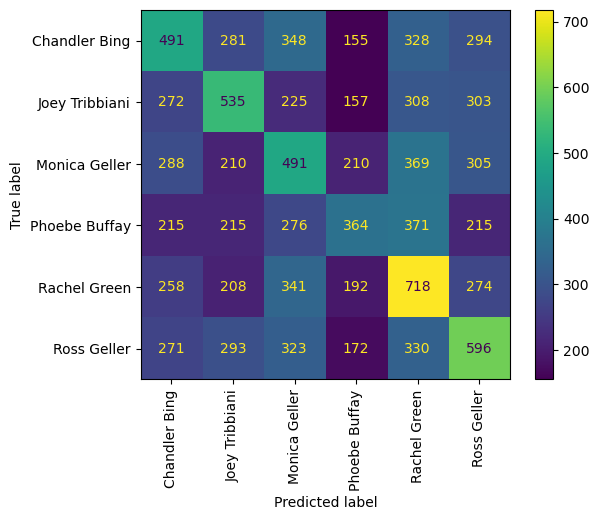

In [18]:
#Plotting a Confusion Matrix to show a comparison between actual and predicted values.
plot_confusion_matrix(estimator=gs_default, X = X_test, y_true=y_test)
plt.xticks(rotation = 90)
plt.show()

In [19]:
print(classification_report(y_test, preds_grid_default))

                precision    recall  f1-score   support

 Chandler Bing       0.27      0.26      0.27      1897
Joey Tribbiani       0.31      0.30      0.30      1800
 Monica Geller       0.25      0.26      0.25      1873
 Phoebe Buffay       0.29      0.22      0.25      1656
  Rachel Green       0.30      0.36      0.33      1991
   Ross Geller       0.30      0.30      0.30      1985

      accuracy                           0.29     11202
     macro avg       0.29      0.28      0.28     11202
  weighted avg       0.29      0.29      0.28     11202



In [20]:
accuracy_score(y_true=y_test, y_pred=preds_grid_default)

0.2852169255490091

----
**Making a dataframe with predictions, actual, and the dialogue**

In [21]:
df_default = pd.DataFrame(y_test)

df_default['predictions'] = preds_grid_default
df_default['dialogue'] = X_test
df_default.rename(columns={'character': 'actual'}, inplace=True)
df_default.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Joey Tribbiani,Then what's the problem?
12970,Phoebe Buffay,Phoebe Buffay,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Phoebe Buffay,What? What? He's interested in you. He-he like...
22017,Monica Geller,Chandler Bing,I've never loved anybody as much as I love you.
5611,Rachel Green,Chandler Bing,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Phoebe Buffay,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Chandler Bing,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Ross Geller,How are you?


In [111]:
#Looking at how many times each character is predicted
df_default['predictions'].value_counts()

Rachel Green      2424
Monica Geller     2004
Ross Geller       1987
Chandler Bing     1795
Joey Tribbiani    1742
Phoebe Buffay     1250
Name: predictions, dtype: int64

In [112]:
#Looking at how many times each character actually appears
df_default['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [22]:
#Seeing how many rows where the actual and the predicted do not match 
df_default.loc[df_default['actual']!= df_default['predictions']].count()

actual         8007
predictions    8007
dialogue       8007
dtype: int64

In [110]:
#Seeing how many rows where the actual and the predicted do match 
df_default.loc[df_default['actual'] == df_default['predictions']].count()

actual         3195
predictions    3195
dialogue       3195
dtype: int64

---
**Predicting Some Phrases**

In [101]:
gs_default.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [102]:
gs_default.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [103]:
gs_default.predict(['We were on a break!'])[0]

'Ross Geller'


<br>

----
### With Parameters!

In [26]:
grid_params_1 = {'cv__stop_words':[None, 'english'],
                'rf__max_depth': [10, 25, 50, 75, 100, 150],
                'rf__min_samples_split': [10, 15, 20, 25, 30]}

In [27]:
#Instaniating a GridSearch
gs_1 = GridSearchCV(estimator=pipe_cv, param_grid= grid_params_1)
gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'rf__max_depth': [10, 25, 50, 75, 100, 150],
                         'rf__min_samples_split': [10, 15, 20, 25, 30]})

In [28]:
#Best parameters
gs_1.best_params_

{'cv__stop_words': None, 'rf__max_depth': 150, 'rf__min_samples_split': 20}

In [120]:
print(f'Train score: {gs_1.score(X_train, y_train)}\nTest score: {gs_1.score(X_test, y_test)}')

Train score: 0.8246042137840733
Test score: 0.30333868951972864


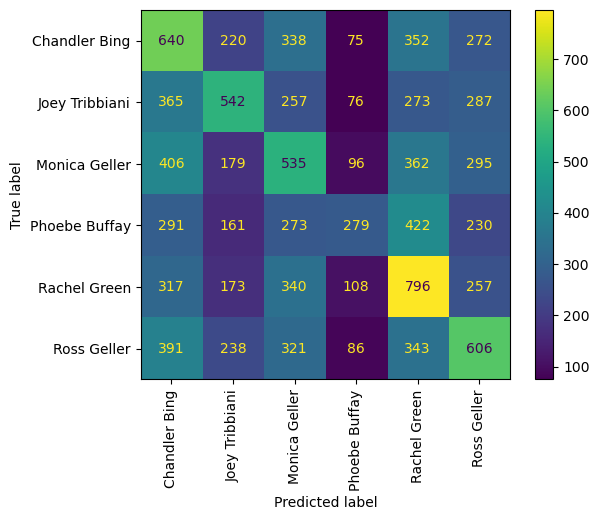

In [31]:
#Plotting a Confusion Matrix to show a comparison between actual and predicted values.
plot_confusion_matrix(estimator=gs_1, X=X_test, y_true=y_test)
plt.xticks(rotation=90)
plt.show()

----
**Making Predictions**

In [32]:
preds_1 = gs_1.predict(X_test)

In [33]:
#Seeing the precision, recall, and f1-score for each class
print(classification_report(y_true=y_test, y_pred=preds_1))

                precision    recall  f1-score   support

 Chandler Bing       0.27      0.34      0.30      1897
Joey Tribbiani       0.36      0.30      0.33      1800
 Monica Geller       0.26      0.29      0.27      1873
 Phoebe Buffay       0.39      0.17      0.23      1656
  Rachel Green       0.31      0.40      0.35      1991
   Ross Geller       0.31      0.31      0.31      1985

      accuracy                           0.30     11202
     macro avg       0.32      0.30      0.30     11202
  weighted avg       0.31      0.30      0.30     11202



In [79]:
#Seeing how accurate the model is
accuracy_score(y_true=y_test, y_pred=preds_1)

0.30333868951972864

---
**Making a dataframe with the actual, predicted, and dialogue**

In [35]:
df_params_1 = pd.DataFrame(y_test)
df_params_1['predictions'] = preds_1 
df_params_1['dialogue'] = X_test
df_params_1.rename(columns={'character': 'actual'}, inplace=True)
df_params_1.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Ross Geller,Then what's the problem?
12970,Phoebe Buffay,Phoebe Buffay,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Monica Geller,What? What? He's interested in you. He-he like...
22017,Monica Geller,Monica Geller,I've never loved anybody as much as I love you.
5611,Rachel Green,Chandler Bing,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Monica Geller,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Chandler Bing,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Monica Geller,How are you?


In [108]:
df_params_1['predictions'].value_counts()

Rachel Green      2548
Chandler Bing     2410
Monica Geller     2064
Ross Geller       1947
Joey Tribbiani    1513
Phoebe Buffay      720
Name: predictions, dtype: int64

In [109]:
df_params_1['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [77]:
gs_default.predict(['Smelly cat, smelly cat, what are they feeding you'])

array(['Phoebe Buffay'], dtype=object)

In [88]:
gs_default.predict(['We were on a break!'])

array(['Ross Geller'], dtype=object)

In [36]:
df_params_1.loc[df_params_1['actual']!= df_params_1['predictions']].count()

actual         7804
predictions    7804
dialogue       7804
dtype: int64

In [107]:
df_params_1.loc[df_params_1['actual']== df_params_1['predictions']].count()

actual         3398
predictions    3398
dialogue       3398
dtype: int64

---
**Predicting Some Phrases**

In [104]:
gs_1.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [105]:
gs_1.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [106]:
gs_1.predict(['We were on a break!'])[0]

'Ross Geller'

----
**Trying other Parameters**

In [38]:
#Trying out more parameters!
grid_params_2 = {'cv__stop_words':[None, 'english'],
                'rf__max_depth': [150, 160, 170, 180, 190, 200],
                'rf__min_samples_split': [10, 15, 20, 25, 30]
}

In [39]:
gs_2 = GridSearchCV(estimator=pipe_cv, param_grid=grid_params_2)
gs_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'rf__max_depth': [150, 160, 170, 180, 190, 200],
                         'rf__min_samples_split': [10, 15, 20, 25, 30]})

In [40]:
gs_2.best_params_

{'cv__stop_words': None, 'rf__max_depth': 180, 'rf__min_samples_split': 25}

In [121]:
print(f"Train score: {gs_2.score(X_train, y_train)}\nTest Score: {gs_2.score(X_test, y_test)}")

Train score: 0.8478454945839781
Test Score: 0.30387430815925726


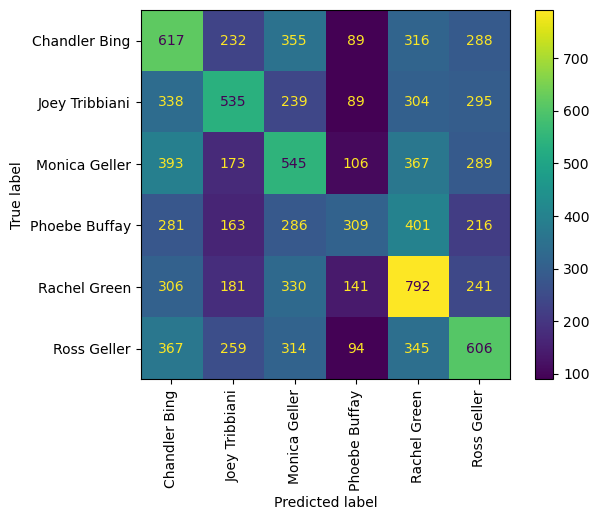

In [80]:
plot_confusion_matrix(estimator=gs_2, X=X_test, y_true=y_test)
plt.xticks(rotation=90)
plt.show()

---
**Making Predictions**

In [42]:
preds_2 = gs_2.predict(X_test)

In [44]:
print(classification_report(y_true=y_test, y_pred=preds_2))

                precision    recall  f1-score   support

 Chandler Bing       0.27      0.33      0.29      1897
Joey Tribbiani       0.35      0.30      0.32      1800
 Monica Geller       0.26      0.29      0.28      1873
 Phoebe Buffay       0.37      0.19      0.25      1656
  Rachel Green       0.31      0.40      0.35      1991
   Ross Geller       0.31      0.31      0.31      1985

      accuracy                           0.30     11202
     macro avg       0.31      0.30      0.30     11202
  weighted avg       0.31      0.30      0.30     11202



In [45]:
accuracy_score(y_test, preds_2)

0.30387430815925726

----
**Making a dataframe with predictions, actual, and the dialogue**

In [46]:
df_params_2 = pd.DataFrame(y_test)
df_params_2['predictions'] = preds_2
df_params_2['dialogue'] = X_test
df_params_2.rename(columns={'character': 'actual'}, inplace=True)
df_params_2.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Ross Geller,Then what's the problem?
12970,Phoebe Buffay,Phoebe Buffay,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Rachel Green,What? What? He's interested in you. He-he like...
22017,Monica Geller,Monica Geller,I've never loved anybody as much as I love you.
5611,Rachel Green,Chandler Bing,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Chandler Bing,Great. So the ball is in his court?
23737,Monica Geller,Ross Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Chandler Bing,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Monica Geller,How are you?


In [113]:
df_params_2['predictions'].value_counts()

Rachel Green      2525
Chandler Bing     2302
Monica Geller     2069
Ross Geller       1935
Joey Tribbiani    1543
Phoebe Buffay      828
Name: predictions, dtype: int64

In [114]:
df_params_2['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [47]:
df_params_2[df_params_2['actual'] != df_params_2['predictions']].count()

actual         7798
predictions    7798
dialogue       7798
dtype: int64

In [48]:
df_params_2[df_params_2['actual'] == df_params_2['predictions']].count()

actual         3404
predictions    3404
dialogue       3404
dtype: int64

---
**Predicting Some Phrases**

In [49]:
gs_2.predict(["How you doin'?"])

array(['Joey Tribbiani'], dtype=object)

In [91]:
gs_2.predict(['Smelly cat, smelly cat, what are they feeding you'])

array(['Phoebe Buffay'], dtype=object)

In [92]:
gs_2.predict(['We were on a break!'])

array(['Ross Geller'], dtype=object)

<br>

-----
### Pipe Using TfidfVectorizer

In [50]:
pipe_tf = Pipeline(steps=[('tf', TfidfVectorizer()),
                         ('rf', RandomForestClassifier(random_state=42))])

### GridSearch with Default Parameters 

In [51]:
grid_tf_d = {'tf__stop_words': [None, 'english'],
            'tf__min_df': [0,1]}

In [52]:
gs_tf_d = GridSearchCV(estimator=pipe_tf, param_grid= grid_tf_d)
gs_tf_d.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'tf__min_df': [0, 1],
                         'tf__stop_words': [None, 'english']})

In [53]:
gs_tf_d.best_params_

{'tf__min_df': 0, 'tf__stop_words': None}

In [122]:
print(f'Train score: {gs_tf_d.score(X_train, y_train)}\nTest Score: {gs_tf_d.score(X_test, y_test)}')

Train score: 0.9532198547791929
Test Score: 0.2959292983395822


---
**Making Predictions**

In [55]:
tf_preds = gs_tf_d.predict(X_test)

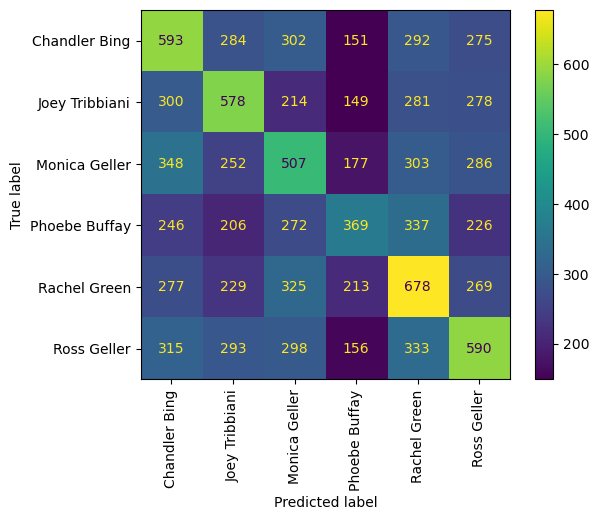

In [81]:
plot_confusion_matrix(estimator= gs_tf_d, X= X_test, y_true= y_test)
plt.xticks(rotation=90)
plt.show()

In [57]:
df_tf_d = pd.DataFrame(y_test)
df_tf_d['predictions'] = tf_preds 
df_tf_d['dialogue'] = X_test
df_tf_d.rename(columns={'character': 'actual'}, inplace=True)
df_tf_d.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Joey Tribbiani,Then what's the problem?
12970,Phoebe Buffay,Phoebe Buffay,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Phoebe Buffay,What? What? He's interested in you. He-he like...
22017,Monica Geller,Chandler Bing,I've never loved anybody as much as I love you.
5611,Rachel Green,Chandler Bing,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Chandler Bing,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Chandler Bing,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Ross Geller,How are you?


In [84]:
df_tf_d['predictions'].value_counts()

Rachel Green      2224
Chandler Bing     2079
Ross Geller       1924
Monica Geller     1918
Joey Tribbiani    1842
Phoebe Buffay     1215
Name: predictions, dtype: int64

In [83]:
df_tf_d['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [59]:
df_tf_d[df_tf_d['actual'] != df_tf_d['predictions']].count()

actual         7887
predictions    7887
dialogue       7887
dtype: int64

In [60]:
df_tf_d[df_tf_d['actual'] == df_tf_d['predictions']].count()

actual         3315
predictions    3315
dialogue       3315
dtype: int64

#### Predicting Some Phrases

In [97]:
gs_tf_d.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [96]:
gs_tf_d.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [95]:
gs_tf_d.predict(['We were on a break!'])[0]

'Ross Geller'

----
### With Parameters! (TfidfVectorizer)

In [62]:
tf_grids_1 = {'tf__stop_words':[None, 'english'],
                'rf__max_depth': [10, 25, 50, 75, 100, 150],
                'rf__min_samples_split': [10, 15, 20, 25, 30]}

In [63]:
tf_gs_1 = GridSearchCV(estimator=pipe_tf, param_grid= tf_grids_1)
tf_gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [10, 25, 50, 75, 100, 150],
                         'rf__min_samples_split': [10, 15, 20, 25, 30],
                         'tf__stop_words': [None, 'english']})

In [64]:
tf_gs_1.best_params_

{'rf__max_depth': 100, 'rf__min_samples_split': 25, 'tf__stop_words': None}

In [124]:
print(f'Train Score: {tf_gs_1.score(X_train, y_train)}\nTest Score: {tf_gs_1.score(X_test, y_test)}')

Train Score: 0.807731222473515
Test Score: 0.295215140153544


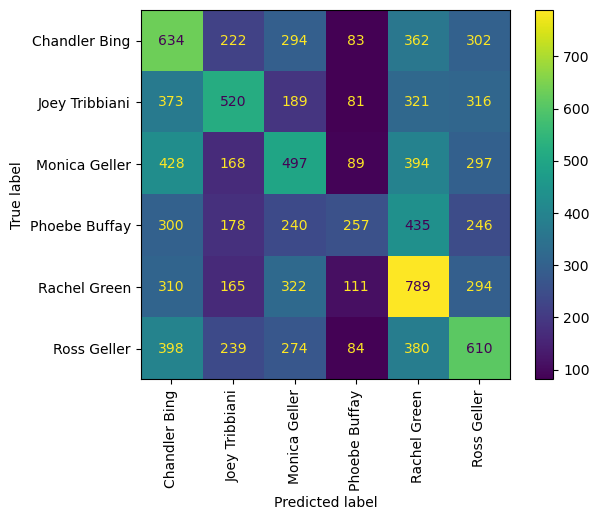

In [67]:
plot_confusion_matrix(estimator=tf_gs_1, X=X_test, y_true=y_test)
plt.xticks(rotation=90)
plt.show()

---
**Making Predictions**

In [68]:
tf_preds_1 = tf_gs_1.predict(X_test)

In [69]:
print(classification_report(y_true=y_test, y_pred=tf_preds_1))

                precision    recall  f1-score   support

 Chandler Bing       0.26      0.33      0.29      1897
Joey Tribbiani       0.35      0.29      0.32      1800
 Monica Geller       0.27      0.27      0.27      1873
 Phoebe Buffay       0.36      0.16      0.22      1656
  Rachel Green       0.29      0.40      0.34      1991
   Ross Geller       0.30      0.31      0.30      1985

      accuracy                           0.30     11202
     macro avg       0.31      0.29      0.29     11202
  weighted avg       0.30      0.30      0.29     11202



In [70]:
accuracy_score(y_true=y_test, y_pred=tf_preds_1)

0.295215140153544

---
**Creating a dataframe with predicted, actual, and dialogue**

In [71]:
tf_df_1 = pd.DataFrame(y_test)
tf_df_1['predictions'] = tf_preds_1 
tf_df_1['dialogue'] = X_test
tf_df_1.rename(columns={'character': 'actual'}, inplace=True)
tf_df_1.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Ross Geller,Then what's the problem?
12970,Phoebe Buffay,Rachel Green,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Monica Geller,What? What? He's interested in you. He-he like...
22017,Monica Geller,Chandler Bing,I've never loved anybody as much as I love you.
5611,Rachel Green,Chandler Bing,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Chandler Bing,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Chandler Bing,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Ross Geller,How are you?


In [116]:
tf_df_1['predictions'].value_counts()

Rachel Green      2681
Chandler Bing     2443
Ross Geller       2065
Monica Geller     1816
Joey Tribbiani    1492
Phoebe Buffay      705
Name: predictions, dtype: int64

In [117]:
tf_df_1['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [72]:
tf_df_1.loc[tf_df_1['actual']!= tf_df_1['predictions']].count()

actual         7895
predictions    7895
dialogue       7895
dtype: int64

In [115]:
tf_df_1.loc[tf_df_1['actual']== tf_df_1['predictions']].count()

actual         3307
predictions    3307
dialogue       3307
dtype: int64

---
**Predicting Some Phrases**

In [98]:
tf_gs_1.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [99]:
tf_gs_1.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [100]:
tf_gs_1.predict(['We were on a break!'])[0]

'Ross Geller'